# Initial Data Exploration  
$$$$
The purpose of our initial data exploration is to:
<ol type = "a">
    <li>Check the validity of the data and perform data cleaning methods if needed.</li>
    <li>View the statistical details of the data</li>
    <li>Perform data visualization to improve our understanding of the data</li>
    <li>Feature engineer</li>
    <li>Sort out the imbalanced dataset</li>
    <li>Perform transformations (standardization, PCA)</li>
</ol>


## Importing required libraries 
Data processing

In [155]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import copy
import random
import pickle
import json

Data Visualization 

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import plotly.graph_objects as go
import squarify 
plt.style.use('ggplot')

Code Styling

In [157]:
from typing import List, Dict

Read in dataframe and bried inspection of the data. 

In [199]:
heart_disease: pd.DataFrame = pd.read_csv("data/heart_2020_cleaned.csv")

## Data Cleaning

Check for missing values 

In [160]:
print(f'Does the heart disease dataset contain any null values? {heart_disease.isnull().any().any()}')

Does the heart disease dataset contain any null values? False


Next, we calculate the basic statistics of each data set. This is a trivial step, and it is designed to increase understanding of the computational problem.

Unique values in the heart disease dataset, stratified by column:
-----------------------------------------------------------------



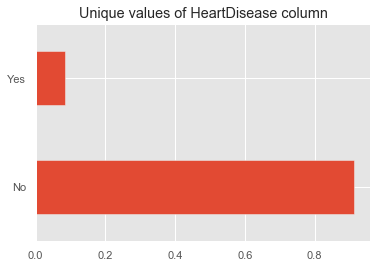

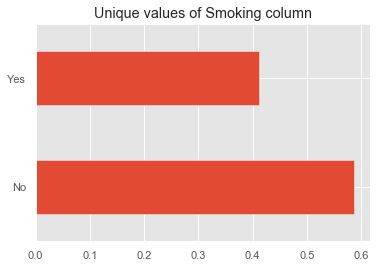

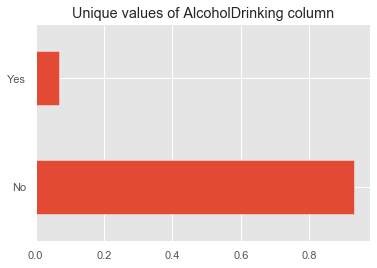

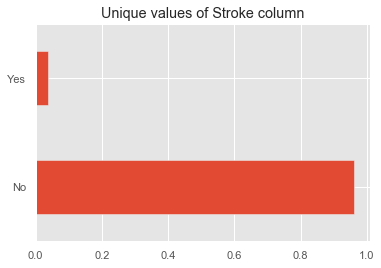

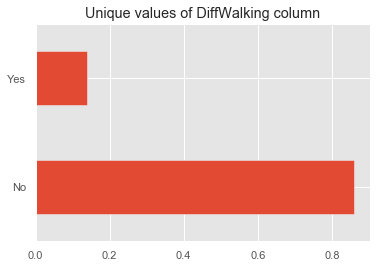

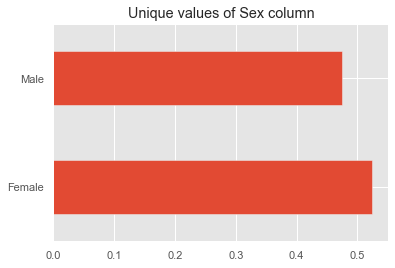

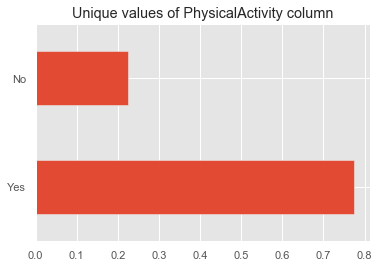

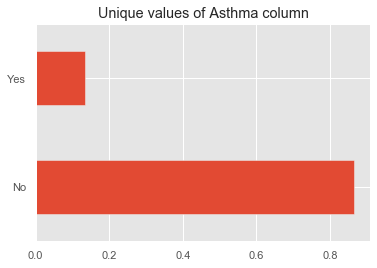

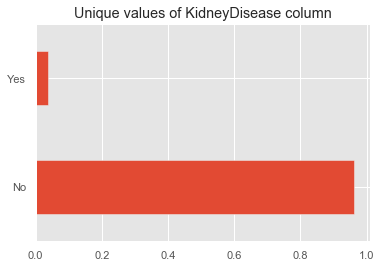

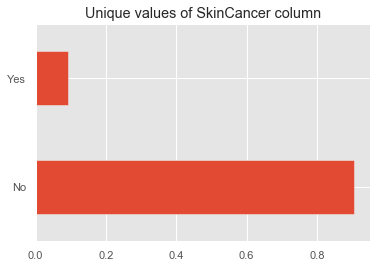

In [161]:
print("Unique values in the heart disease dataset, stratified by column:", sep='')
print("-----------------------------------------------------------------\n")
for col in heart_disease.columns:
    if heart_disease[col].nunique() < 20:
        if heart_disease[col].nunique() < 3: 
            heart_disease[col].value_counts(normalize=True).plot(kind='barh', title=f"Unique values of {col} column", )
            plt.show()

From this we note the this dataset is imbalanced .i.e, data set with skewed class proportions. This is a common problem in classification problems. We will address this issue later in the notebook.

In [162]:
heart_disease.describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,319795.000000,319795.00000,319795.000000,319795.000000
mean,28.325399,3.37171,3.898366,7.097075
std,6.356100,7.95085,7.955235,1.436007
min,12.020000,0.00000,0.000000,1.000000
25%,24.030000,0.00000,0.000000,6.000000
50%,27.340000,0.00000,0.000000,7.000000
75%,31.420000,2.00000,3.000000,8.000000
max,94.850000,30.00000,30.000000,24.000000


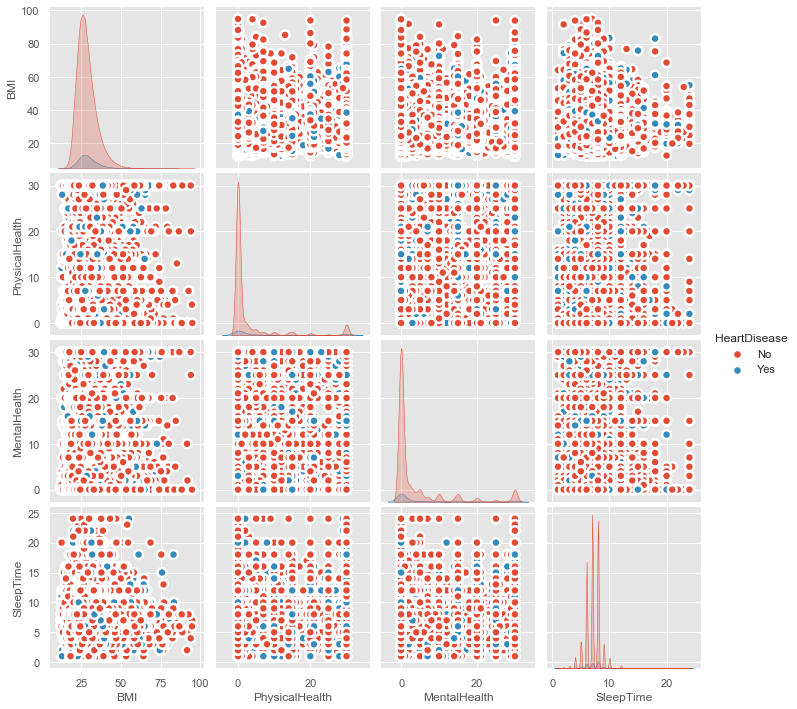

In [163]:
sns.pairplot(heart_disease[
    ["HeartDisease", "BMI", "PhysicalHealth", "MentalHealth", "SleepTime"]
    ], hue="HeartDisease", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

Surprisingly, the distribution of BMI, mental health and sleep time don't seem to be significantly different when comparing with people who **do or do not** have heart disease. However, the mental health do seem to have a strong correlation with heart disease.

# Data Visualization

To familiarize ourself with the data, we generate plots that seek to illuminate some research questions. 

1. Are people from certain backgrounds more likely to have heart disease, given their ethnicity?
2. Is the percentage of females and males with heart disease similar?
3. Do peoples *reported* physical activity correlate with their physical health?
4. Which risk factors are most correlated with heart disease?
5. What is the flow of patients from  their age to substance misuse to if they have an aliment listed in the dataset to  their likelihood of contracting heart disease?

In [164]:
def create_stacked_bar_hart(heart_disease: pd.DataFrame) -> plt.figure:
    """
    Args:
        heart_disease (pd.DataFrame): the original heart disease kaggle dataset

    Returns:
        plt.figure: a stacked bar chart of the percentage of people 
            with heart disease and without heart disease, stratified by race
    """

    # top bar -> sum all values(HeartDisease=No and HeartDisease=Yes) to find y position of the bars
    total: pd.DataFrame = heart_disease.groupby('Race').count().reset_index()

    # bar chart 1 -> top bars (group of 'HeartDisease=No')
    bar1: sns.barplot = sns.barplot(x="Race",  y="HeartDisease", data=total, color='red')

    # bottom bar ->  take only HeartDisease=Yes values from the data
    HeartDisease: pd.DataFrame = heart_disease[heart_disease.HeartDisease=='Yes'].groupby('Race').count().reset_index()


    # bar chart 2 -> bottom bars (group of 'HeartDisease=Yes')
    bar2: sns.barplot = sns.barplot(x="Race", y="HeartDisease", data=HeartDisease, errorbar=None,  color='green')

    # add legend
    top_bar: mpatches.Patch = mpatches.Patch(color='red', label='HeartDisease = No')
    bottom_bar: mpatches.Patch = mpatches.Patch(color='green', label='HeartDisease = Yes')
    plt.legend(handles=[top_bar, bottom_bar])
    plt.ylabel('Number of Patients')
    plt.xticks(rotation=45,ha='right')
    # show the graph
    plt.show()

In [165]:
def create_tree_diagram(heart_disease:pd.DataFrame) -> squarify.plot:
    """
    Args:
        heart_disease (pd.DataFrame): the original heart disease kaggle dataset

    Returns:
        squarify.plot: A tree diagram displaying the number of males and females 
            that do and don't have heart disease
    """
    heart_disease = heart_disease.copy()
    tree_diagram_df: pd.DataFrame = heart_disease.groupby(['Sex', 'HeartDisease']).count().reset_index()[['Sex','HeartDisease','BMI']]
    tree_diagram_df['Gender_choice'] = tree_diagram_df[['Sex', 'HeartDisease']].agg(', '.join, axis=1)
    tree_diagram_df.rename(columns={'BMI': 'count'}, inplace=True)
    squarify.plot(sizes=tree_diagram_df['count'], label=tree_diagram_df['Gender_choice'], alpha=.4)
    plt.axis('off')
    plt.show()

def create_histplot(heart_disease:pd.DataFrame) -> plt.figure:
    """
    Args:
        heart_disease (pd.DataFrame): the original heart disease kaggle dataset

    Returns:
        plt.figure: Two histograms displaying the number of days in the past 30 days
                    in which patients were physically active. 
                    Stratified by people's reported physical health
    """
    heart_disease = heart_disease.copy()
    sns.set(style="darkgrid")
    heart_disease = heart_disease[heart_disease.PhysicalHealth > 0]
    # plotting both distibutions on the same figure
    sns.histplot(heart_disease[heart_disease.PhysicalActivity == 'Yes']['PhysicalHealth'], color="skyblue", label="People who report doing physical activity")
    sns.histplot(heart_disease[heart_disease.PhysicalActivity == 'No']['PhysicalHealth'], color="red", label="People who do not physical activity")
    plt.legend()
    plt.xlabel("People who report that their physical health (physical illness and injury) was not good? (0-30 days).")
    plt.show()
    
    

In [166]:
def create_corr_plot(heart_disease: pd.DataFrame):
    """
    Args:
        heart_disease (pd.DataFrame): the original heart disease kaggle dataset

    Returns:
        squarify.plot: A bar chart displaying the correlation of risk factors vs  heart disease 
    """
    heart_disease = heart_disease.copy()
    binary_vars: List[str] = ["HeartDisease", 
                        "Smoking",
                        "AlcoholDrinking",
                        "Stroke", 
                        "DiffWalking",
                        "Diabetic",
                        "PhysicalActivity",
                        "Asthma",
                        "KidneyDisease",
                        "SkinCancer"]
    for binary_var in binary_vars:
        heart_disease[binary_var] = heart_disease[binary_var].replace({"Yes": 1, "No": 0})
    heart_disease.Diabetic = heart_disease.Diabetic.replace({'No, borderline diabetes': 1, 'Yes (during pregnancy)' : 1}).astype(int)
    heart_disease.corr()[['HeartDisease']].plot.bar(legend=False)
    plt.title("Correlations of HeartDisease variable vs risk factors")
    

In [167]:
def create_sankey_chart(sankey_data:pd.DataFrame) -> go.Figure:
  """
  Args:
      heart_disease (pd.DataFrame): contains three columns; source target value. 
                                    Indicates the amount of patients moving through each stage of the sankey chart

  Returns:
      go.Figure: A sankey chart indicating the flow of patients in the following pattern:
                    Age -> Substance Abuse -> Alinement -> Heart Disease outcome
        
  """
  sankey_data = sankey_data.copy()
  # Get unique values for both source and target columns
  unique_source_target_values  = list(pd.unique(sankey_data[['source', 'target']].values.ravel('K')))

  source_target_mapping = {k:v for v,k in enumerate(unique_source_target_values)}
  with open("data/color_sankey_dict.json") as f:
      colour_dict= json.loads(f.read())
  links = sankey_data[['source', 'target', 'value']].copy()

  links["source"] = links["source"].map(source_target_mapping)
  links["target"] = links["target"].map(source_target_mapping)
  links_dict = links.to_dict(orient="list")

  with open('data/link_colours.pkl', 'rb') as f:
      link_colours = pickle.load(f)
      
  fig = go.Figure(data = [go.Sankey(
      valueformat = ".0f",
      valuesuffix = "TWh",
      # Define nodes
      node = dict(
        pad = 15,
        thickness = 15,
        line = dict(color = "black", width = 0.2),
        label =  unique_source_target_values,
        color =  list(colour_dict.values())
      ),
      link = dict(
        source = links_dict["source"],
        target = links_dict["target"],
        value = links_dict["value"],
        color= link_colours,
      )
          
      )]
  )
  fig.update_layout(title_text="Patient Flow <br> Age -> Substance Abuse -> Alinement -> Heart Disease outcome",
                    font_size=10)
  fig.show()

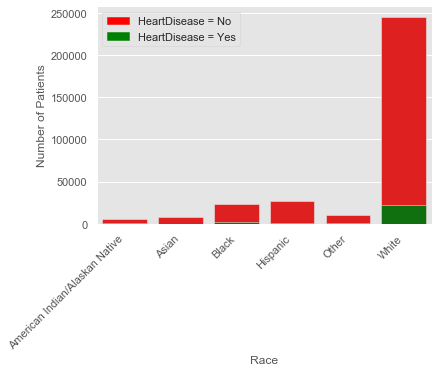

In [168]:
create_stacked_bar_hart(heart_disease)

White people appear to both appear most often in this dataset and have the highest prevalence of heart disease in the their sub-population. The race with the second most heart disease prevalance is heart disease.

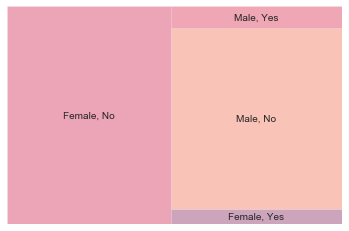

In [169]:
create_tree_diagram(heart_disease)

It is evident that relataive rate of heart disease is higher in men than in women.

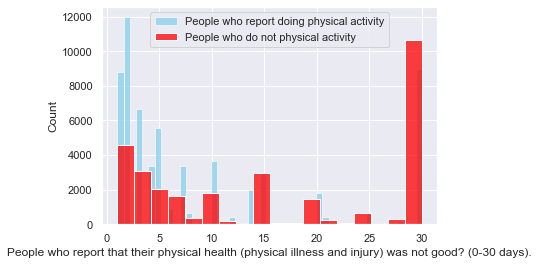

In [170]:
create_histplot(heart_disease)

Surprisingly, it seems that peoples reported physical health does not necessarily align with their physical activity levels.

In [171]:
sankey_data: pd.DataFrame = pd.read_csv('data/full_sankey_data.csv')
create_sankey_chart(sankey_data)

## Feature Engineering

A lot of our features contain categorical data. We will need to convert these to numerical values. Feature extraction projects the original high-dimensional features to a new feature space with low dimensionality, while feature selection directly selects a subset of relevant features. Both feature extraction
and feature selection can improve learning performance, increase computational efficiency, decrease memory storage, and build better
generalization models. However, as feature extraction creates a set of new features, further analysis is problematic as we cannot retain the
physical meanings of these features. In contrast, by keeping some of the original features, feature selection maintains the physical
meanings of the original features and gives models better readability and interpretability.

The columns broadly fall into three categories:

    - Binary Categorical variables
      -  HeartDisease
      -  Smoking 
      -  AlcoholDrinking
      -  Stroke 
      -  DiffWalking
      -  Diabet   
      -  Physical Activity
      -  Asthma
      -  Kidney Disease
      -  Skin Cancer
      -  Sex
    - Continuous variables
      - BMI
    - Discrete variables
      - Sleeptime
      - PhsycialHealth
      - MentalHealth
    - Polytomous variables; these are variables with more than two categories
      - AgeCategory
      - Race 
      - GenHealth

Binary variables with yes or no values are converted to 1 and 0 respectively. The diabetes column currently has four categories: 'Yes', 'No', 'No, borderline diabetes', 'Yes (during pregnancy)'. Our earlier analysis revealed that  the presence of heart dieasease and diabetes are weakly correlated. Therefore, we will combine the 'Yes (during pregnancy)' and 'No, borderline diabetes' categories into the 'Yes' category.


In [172]:
heart_disease['Diabetic'].unique()

array(['Yes', 'No', 'No, borderline diabetes', 'Yes (during pregnancy)'],
      dtype=object)

In [173]:
binary_vars: List[str] = ["HeartDisease", 
                        "Smoking",
                        "AlcoholDrinking",
                        "Stroke", 
                        "DiffWalking",
                        "Diabetic",
                        "PhysicalActivity",
                        "Asthma",
                        "KidneyDisease",
                        "SkinCancer"]

In [174]:
for binary_var in binary_vars:
    heart_disease[binary_var] = heart_disease[binary_var].replace({"Yes": 1, "No": 0})
heart_disease.Diabetic: pd.Series = heart_disease.Diabetic.replace({'No, borderline diabetes': 1, 'Yes (during pregnancy)' : 1}).astype(int)

In [175]:
# One-hot encoding 
sex_one_hot = pd.get_dummies(heart_disease['Sex'])
heart_disease = heart_disease.join(sex_one_hot)
heart_disease.drop(columns=['Sex'], inplace=True)

In the dataset, ordinal attributes are present. There is a natural ordering to the categories (i.e. GenHealth, AgeCategory). Thus, we use the `replace()` function to label encode them. 

In [177]:
heart_disease["AgeCategory"].replace({
    '18-24':1,
    '25-29':2,
    '30-34':3,
    '35-39':4,
    '40-44':5,
    '45-49':6,
    '50-54':7,
    '55-59':8,
    '60-64':9,
    '65-69':10,
    '70-74':11,
    '75-79':12,
    '80 or older':13
}, inplace=True)

In [178]:
heart_disease["GenHealth"].replace({
    'Poor': 1,
    'Fair':2, 
    'Good':3, 
    'Very good':4,  
    'Excellent':5},
    inplace=True)

Race has no order. Therefore, we decide to take two approaches. 

- One-hot-encoding:Increase the dimensions to facilite a better feature selection space step later which produces a final lower dimension feature vector (i.e. every race is a binary feature)
- Frequency encoding:  Frequency Encoding is an encoding technique that encodes categorical feature values to their respected frequencies. This will preserve the information about the values of distributions. We normalize the frequencies that result in getting the sum of unique values as 1. This is done to avoid the curse of dimensionality and reduce the sparsity in the dataset.

We will evaluate both approaches in our model evaluation. 

In [179]:
# One-hot encoding 
race_one_hot: pd.DataFrame = pd.get_dummies(heart_disease['Race'])
heart_disease: pd.DataFrame = heart_disease.join(race_one_hot)

# Frequency encoding using value_counts function 
race_freq: pd.Series = heart_disease['Race'].value_counts(normalize=True)

# Mapping the encoded values with original data 
heart_disease['Race_freq']: pd.Series = heart_disease['Race'].apply(lambda x : race_freq[x])
heart_disease.drop(columns=['Race'], inplace=True)

Outliers are extreme values. Outliers can skew the distribution but these are exceptional but genuine data points.  Such distributions can impact certain algorithms such as regression type models (Lasso), k Nearest neighbors and Naive Bayes. However, decision trees and its ensemble (random forest) are not impacted. 

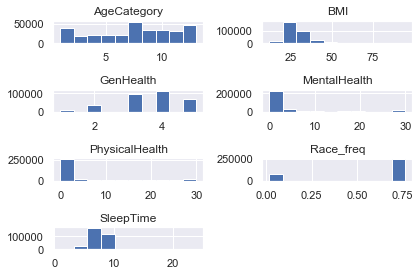

In [180]:
heart_disease.hist(column=["BMI",
     "SleepTime",
     "PhysicalHealth",
     "MentalHealth",
     "AgeCategory",
     "Race_freq", 
     "GenHealth"], layout=(4,2))
plt.tight_layout()

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff54872a250>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff54872ad50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff5cff6af50>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff5487dfcd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff54872ab10>],
 'means': []}

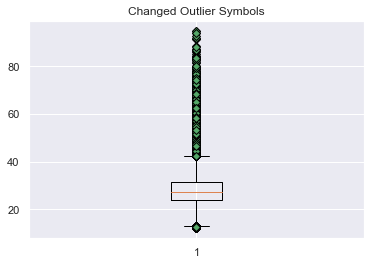

In [181]:
green_diamond: Dict[str, str] = dict(markerfacecolor='g', marker='D')
fig1, ax1 = plt.subplots()
ax1.set_title('Changed Outlier Symbols')
ax1.boxplot(heart_disease["BMI"], flierprops=green_diamond)

We note that many outliers exist in the BMI column. To rectify this, we take two approaches 

- **Turn it into a ordinal variable**: The WHO uses BMI as a convenient rule of thumb used to broadly categorize a person as underweight, normal weight, overweight, or obese based on tissue mass (muscle, fat, and bone) and height. Major adult BMI classifications are underweight (under 18.5 kg/m2), normal weight (18.5 to 24.9), overweight (25 to 29.9), and obese (30 or more). We will encode these describe caegories into ordinal values.
- **Take log(x) of the BMI column**: Taking the log of a feature is a common trick to reduce the effect of outliers. This is because the log function is monotonically increasing. Therefore, the effect of outliers is reduced.
Again, both aproaches will be evaluated in our model evaluation.

In [182]:
bins: List[int] = [0, 18.5, 24.9, 29.9, np.inf]
names: List[int] = [1, 2, 3, 4]
heart_disease['BMI_Bin']: pd.Series = pd.cut(heart_disease['BMI'], bins, labels=names)

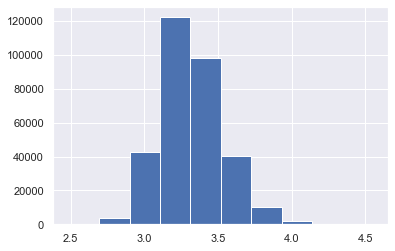

In [183]:
heart_disease["LOG_BMI"]: pd.Series = np.log(heart_disease["BMI"])
heart_disease["LOG_BMI"].hist()

### PCA

Standardization is typically used for features of incomparable units. E.g. someone reporting the number of times they were physical active in the last thirty days and BMI. Standardisation will be applied to all features (both orginal and engineered) except the binary variables. We will also standardize the features due to k-means “isotropic” nature. In this case, if we left our variances unequal; we would inversely be putting more weight on features with high variance. In addition, we will perform principal component analysis due to avoid the curse of dimensionality that k-means can suffer from. The function of PCA is to reduce the dimensionality of a data set consisting of many variables correlated with each other, either heavily or lightly, while retaining the variation present in the data set to the maximum extent.

The same is done by transforming the variables (i.e. features) to a new set of variables, which are known as the principal components, ordered such that the retention of variation present decreases as we move down the order of components.

In addition, we will perform principal component analysis due to avoid the curse of dimensionality that some algorithims can suffer from. Initally, PCA is only perfoormed on the *features present within the orginal dataset*. Later on,  we will perform A feature extraction method u by applying different subsets  of training  data to estimate the accuracy of these subsets for all used
classifiers and measure the quality of the generated subsets  per classification algorithm, and the results of the classifier are shown. We plan to use PCA again for those best performing subets to see if any improvement is made.


The function of PCA is to reduce the dimensionality of a data set consisting of many variables correlated with each other,
either heavily or lightly, while retaining the variation present in the data set to the maximum extent.

The same is done by transforming the variables (i.e. features) to a new set of variables, which are known as the <b>principal components</b>, ordered such that the retention of variation present decreases as we move down the order of components. 


The procedure of PCA involves five steps: <br>
1) Standardize the data <br>
2) Compute covariance matrix <br>
3) Identify the eigenvalues and eigenvectors of the covariance matrix and order them according to the eigenvalues <br>
4) Compute a feature vector <br>
5) Recast the data <br>


#### Standardisation

We now standardize the data using the following formulae:

$$
X_i = X_i - \bar{X}~~~~~~~~~~~~~~~~~~X_i = \frac{X_i}{\sigma}
$$

The standard deviation should equal 1 after standardization

In [184]:
heart_disease[
    ['PhysicalHealth', 'MentalHealth', 'AgeCategory', 'GenHealth','SleepTime', 'BMI_Bin']
    ] = StandardScaler().fit_transform(heart_disease[['PhysicalHealth', 'MentalHealth', 'AgeCategory', 'GenHealth','SleepTime', 'BMI_Bin']])

In [185]:
heart_disease.to_csv('data/standardised_heart_disease.csv', index=False)

We will use the `PCA` function supplied by the `Scikit-learn` library for dimensionality reduction.  But how do we find the optimal number of components? Which eigenvalues are important?  The scree plot below describes the cumulative explained variance for each component. We reach 80% explained variance at the three component mark.

In [186]:
orginal_features_df: List[str] = heart_disease[[ 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'AgeCategory', 'PhysicalActivity', 'GenHealth', 'SleepTime', 'Asthma',
       'KidneyDisease', 'SkinCancer', 'Female', 'Male',
       'American Indian/Alaskan Native', 'Asian', 'Black', 'Hispanic', 'Other',
       'White']]

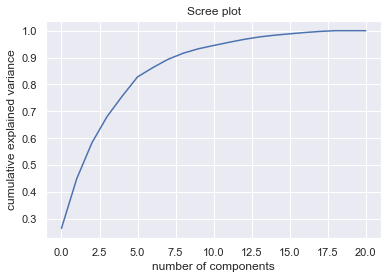

In [187]:
pca = PCA().fit(orginal_features_df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Scree plot')
plt.show()

We note a slight indent at the the 5th principal compent mark. According to the average-eigenvalue test (Kaiser-Guttman test) we should retain only those eigenvalues that are above the average which is 1.0. <br>
Jolliffe relaxes this criterium and suggest to retain eigenvalues greater than 0.7. 


In [188]:
kasier_criterion: np.int64 = np.where(pca.explained_variance_ > 1)[-1][-1]
print(
        f'Kasier criterion optimal component number: {kasier_criterion}, explained variance: {np.cumsum(pca.explained_variance_ratio_)[kasier_criterion]}'
    )
jolliffe_criterion: np.int64  = np.where(pca.explained_variance_ > 0.7)[-1][-1]
print(
    f'Jolliffe criterion optimal component number: {jolliffe_criterion} , explained variance: {np.cumsum(pca.explained_variance_ratio_)[jolliffe_criterion]}'
    )

Kasier criterion optimal component number: 1, explained variance: 0.44862010192447693
Jolliffe criterion optimal component number: 2 , explained variance: 0.58254445411681


 For the purpose of this investigation, we decide to go with **both** the Jolaliffe criterion, we will retain the first two  components.

Finally, we fit the `pca` model with the dataframes containing top 2 components , apply the dimensionality reduction on those respective dataframe and save the resulting dataframes.

In [189]:
pca_2d = PCA(n_components=2)
dim_reduced_2d: pd.DataFrame = pca_2d.fit_transform(orginal_features_df)
dim_reduced_2d = pd.DataFrame(data=dim_reduced_2d, columns=[f'component_{num}' for num in range(1,3)])
dim_reduced_2d = pd.merge(
        heart_disease[['HeartDisease']], dim_reduced_2d, left_index=True, right_index=True
        )
dim_reduced_2d.to_csv("data/dim_reduced_2d.csv", index=False)

**Note**, later on we will use PCA to identify the variables that contribute most to the variation in the dataset.